In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# Загрузка данных
data = pd.read_csv("./Data/X_train.csv")
data.drop(labels="measurement_number", axis=1 , inplace=True)
data = data.groupby("series_id").agg(['mean', 'std', 'median'])
data.columns = [f'{col}_{stat}' for col, stat in data.columns]
data = data.reset_index()
data.drop(labels=["series_id","row_id_mean","row_id_std", "row_id_median"], axis=1 , inplace=True)
data = data.round(2).to_numpy(dtype=np.float64)
y = pd.read_csv("./Data/y_train.csv")["group_id"].to_numpy(dtype=np.int64)

In [46]:
# Класс, который в последствии добавляется в словарь для удобного выбора
class Node:
    def __init__(
        self,
        feature=None,
        threshold=None,
        childs=None,

        value=None,
        proba_value = None,
        veroyat = 0
    ):
        self.feature = feature
        self.threshold = threshold
        self.childs = childs
        self.value = value
        self.proba_value = proba_value
        self.veroyat = veroyat

    def is_leaf_node(self):
        return self.value is not None
    


class DecisionTree:
    def __init__(self, max_depth=10, min_samples=10):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.tree = None
        self.classes = None
        self.X_count = None


    def fit(self, X, y):
        self.classes = np.unique(y)
        self.X_count = X.shape[0]
        self.tree = self.grow_tree(X, y)

    def calck_unic(self, a: list):
        keys = np.unique(a)
        return (a[a == key].shape[0] for key in keys), keys

    def predict(self, X):
        return np.array([self.travers_tree(x, self.tree) for x in X])

    def predict_proba(self, X):
        return np.array([self.travers_proba_tree(x, self.tree) for x in X])

    def entropy(self, y: np.ndarray):
        hist, _ = self.calck_unic(y)
        n = y.shape[0]
        info = -np.sum(np.fromiter((val/n * np.log2(val/n) for val in hist), dtype=np.float64))

        return info
    
    #======================================
    def gini(self, y:np.ndarray):
        uitems = self.calck_unic(y)
        n = y.shape[0]
        return 1 - np.sum(np.fromiter(((val/n)**2 for val in uitems), dtype=np.float64))
    #======================================

    def information_gain(self, X_column: list, y: list):
        if np.unique(y).shape[0] == 1:
            return 0

        n = y.shape[0]
        parent = self.entropy(y)
        uitems, keys = self.calck_unic(X_column)
        uitems = [i for i in uitems]

        info_x = np.sum(
            [uitems[i] / n * self.entropy(y[X_column == keys[i]]) for i in range(len(uitems))]
        )

        split_info = -np.sum(
            [val / n * np.log2(val / n) for val in uitems if val > 0]
        )

        if split_info != 0:
            return (parent - info_x) / split_info, keys
        else:
            return 0, keys

    def most_common(self, y):
        labels = np.unique(y)
        vals, _ = self.calck_unic(y)
        return labels[np.argmax(vals)]

    def proba_val(self, y):
        n = y.shape[0]
        probas = np.zeros(self.classes.shape[0])
        vals, keys = self.calck_unic(y)

        probas[np.in1d(self.classes, keys)] = np.fromiter(vals, dtype=np.float64) / n
        return probas

    def best_split(self, X, y):
        best_feature = None
        best_gain = -1

        for i in range(X.shape[1]):
            gain, now_uitems = self.information_gain(X[:, i], y)

            if gain > best_gain:
                best_gain = gain
                best_feature = i
                uitems = now_uitems

        return best_feature, uitems

    def grow_tree(self, X, y, depth=0):
        n_samples = X.shape[0]
        n_labels = np.unique(y).shape[0]

        if n_samples <= self.min_samples or depth >= self.max_depth or n_labels <= 1:
            return Node(value=self.most_common(y), proba_value=self.proba_val(y))

        best_feature, ukeys = self.best_split(X, y)

        # В словаре содержатся не словари, а Node По сути, словарь содержит ссылки на объекты, а нужен он для более удобной навигации.
        childs = {
            key: self.grow_tree(
                X[X[:, best_feature] == key],
                y[X[:, best_feature] == key],
                depth=depth + 1,
            )
            for key in ukeys
        }

        return Node(best_feature, childs=childs, veroyat = X.shape[0] / self.X_count)


    def travers_tree(self, x, tree):
        if tree.is_leaf_node():
            return tree.value

        return self.travers_tree(
            x,
            tree.childs.get(
                x[tree.feature], tree.childs.get(list(tree.childs.keys())[0])
            ),
        )

    def travers_proba_tree(self, x, tree):
        if tree.is_leaf_node():
            return tree.proba_value

        max_ver = 0
        for key, child  in tree.childs.items():
            if child.veroyat >= max_ver:
                max_ver = child.veroyat
                new_child = key

        return self.travers_proba_tree(
            x,
            tree.childs.get(
                x[tree.feature], tree.childs.get(new_child) #list(tree.childs.keys())[0])
            ),
        )


In [38]:
class RandomForest:
    def __init__(self, n_trees = 10, max_deep = 10, min_samples = 10):
        self.trees = [0 for i in range(n_trees)]
        self.tree_inds = [0 for i in range(n_trees)]
        self.n_trees = n_trees
        self.max_deep = max_deep
        self.min_samples = min_samples
        self.num_classes=None

    def fit(self, X, y):
        n_features = int(X.shape[1]**0.5+0.5)
        # n_features = X.shape[0]
        self.num_classes = np.unique(y).shape[0]

        for i in range(self.n_trees):
            clf = DecisionTree(max_depth=self.max_deep, min_samples=self.min_samples)
            inds =  np.random.choice(np.arange(X.shape[1]), n_features)
            # inds =  np.random.choice(np.arange(X.shape[0]), n_features, replace=True)
            clf.fit(X[:, inds], y)
            # print(y)
            # clf.fit(X, y)
            # print(clf.predict(x_test[:,inds ]))
            self.trees[i] = clf
            self.tree_inds[i] = inds
    
    def predict(self, X):
        otv = np.zeros((X.shape[0], self.num_classes))
        
        for i, clf in enumerate(self.trees):
            otv[np.arange(X.shape[0]), clf.predict(X[:, self.tree_inds[i]])] += 1
            # otv[np.arange(X.shape[0]), clf.predict(X)] += 1
            # print(otv)
        # print(otv)
        return np.argmax(otv, axis=1)
    
    def predict_proba(self, X):
        otv = np.zeros((X.shape[0], self.num_classes))
        for i, clf in enumerate(self.trees):
            otv += clf.predict_proba(X[:, self.tree_inds[i]])

        return otv
    
    

In [53]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2)
clf = RandomForest(n_trees=1300, max_deep=90)
clf.fit(X_train, y_train.flatten())
otv_proba = clf.predict_proba(X_test)
otv = np.argmax(otv_proba, axis = 1)

In [54]:
def AUC_ROC(y_true, y_pred_proba, class_ind=1):
    y_pred_proba_true = y_pred_proba[np.argmax(y_pred_proba, axis=1) == class_ind, class_ind]

    sorted_indices_true = np.argsort(y_pred_proba_true)[::-1]
    sorted_indices_false = np.argsort(y_pred_proba[np.argmax(y_pred_proba, axis=1) != class_ind, class_ind])
    sorted_indices = np.hstack((sorted_indices_true, sorted_indices_false))
    sorted_y_true = y_true[sorted_indices]
    sorted_y_pred = y_pred_proba[sorted_indices]

    otv_list_y = []
    otv_list_x = []
    flag_y = 0
    flag_x = 0
    for y in sorted_y_true:
        if y == 1:
            flag_y+=1
        else:
            flag_x += 1
        otv_list_y.append(flag_y)
        otv_list_x.append(flag_x)

    otv_list_x = np.array(otv_list_x)
    otv_list_y = np.array(otv_list_y)
    plt.plot(otv_list_x/otv_list_x[-1], otv_list_y/otv_list_y[-1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'AUC - ROC Curve for class: {class_ind}')
    plt.show()


def AUC_ROC_one_vs_all(y_true):
    for i in np.sort(np.unique(y_true)):
        print(i)
        AUC_ROC(np.where((y_true) == i, 1, 0), otv_proba, class_ind=i)

In [55]:
def pre_rec_f1(y_true, y_pred):
    precision_list = []
    recall_list = []
    f1_list = []
    for i in np.unique(y_true):
        tp = np.sum((y_pred == i) * (y_true == i))
        fp = np.sum((y_pred==i) * (y_true != i))
        fn = np.sum((y_pred!=i) * (y_true == i))
        precision = tp/max(tp+fp, 1)
        recall = tp/max(tp+fn, 1)
        f1 = 2*precision*recall/max((precision+recall, 0.000001))

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

        print(f"For {i} class {precision=}")
        print(f"For {i} class {recall=}")
        print(f"For {i} class {f1=}")
    
    print(f"Macro precision = {sum(precision_list)/len(precision_list)}")
    print(f"Macro recall = {sum(recall_list)/len(recall_list)}")
    print(f"Macro f1 = {sum(f1_list)/len(f1_list)}")
    print(f"accuracy = {np.sum(y_pred==y_true)/y_true.shape[0]}")

pre_rec_f1(y_test.flatten(), otv)

For 0 class precision=0.2631578947368421
For 0 class recall=0.8333333333333334
For 0 class f1=0.39999999999999997
For 1 class precision=0.75
For 1 class recall=0.3333333333333333
For 1 class f1=0.46153846153846156
For 2 class precision=1.0
For 2 class recall=0.3333333333333333
For 2 class f1=0.5
For 3 class precision=0.375
For 3 class recall=0.2727272727272727
For 3 class f1=0.3157894736842105
For 4 class precision=0.875
For 4 class recall=1.0
For 4 class f1=0.9333333333333333
For 6 class precision=0.75
For 6 class recall=0.3333333333333333
For 6 class f1=0.46153846153846156
For 7 class precision=0.23529411764705882
For 7 class recall=0.4
For 7 class f1=0.29629629629629634
For 8 class precision=0.5
For 8 class recall=0.75
For 8 class f1=0.6
For 9 class precision=0.5454545454545454
For 9 class recall=0.42857142857142855
For 9 class f1=0.4799999999999999
For 10 class precision=0.2857142857142857
For 10 class recall=0.2222222222222222
For 10 class f1=0.25
For 11 class precision=0.72727272

0


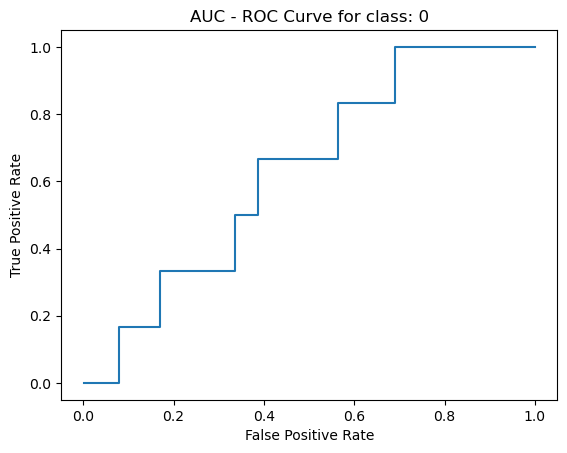

1


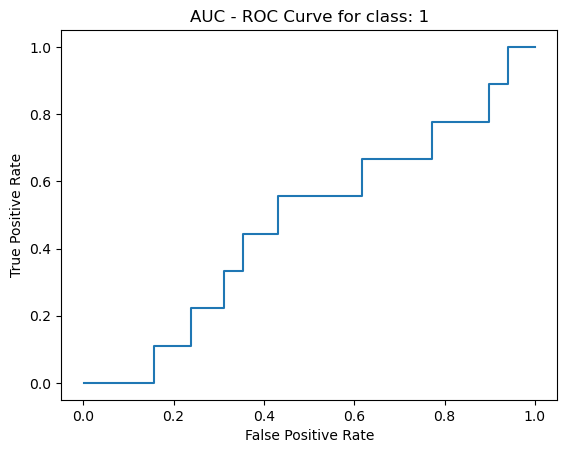

2


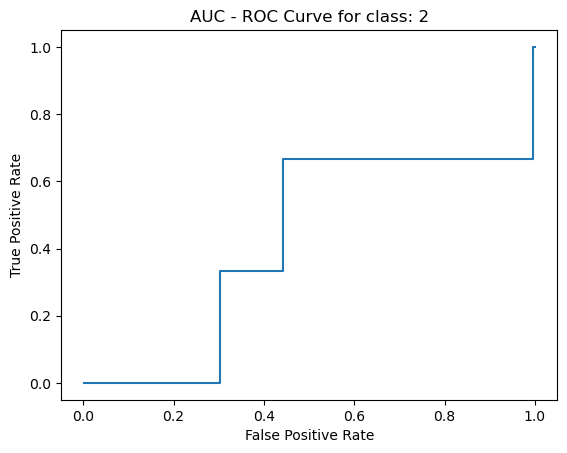

3


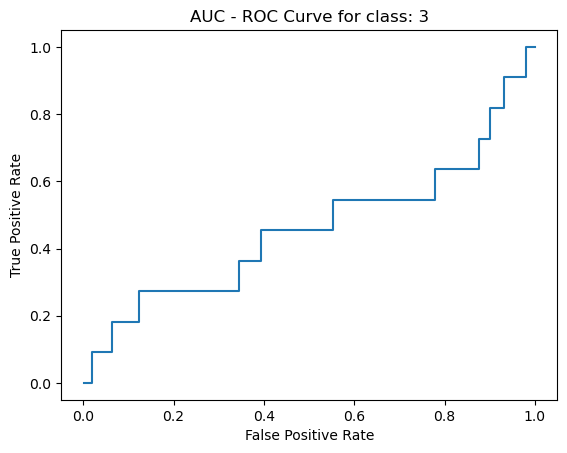

4


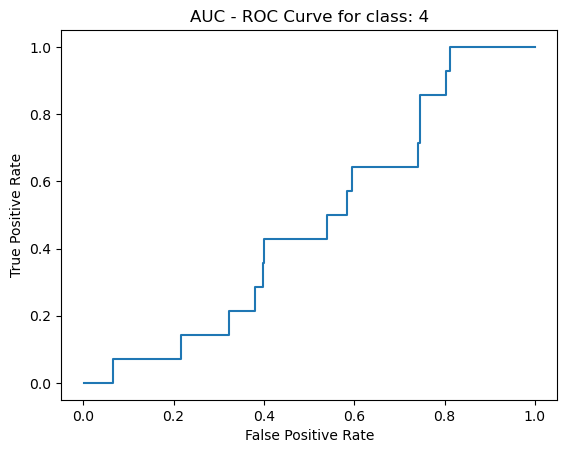

6


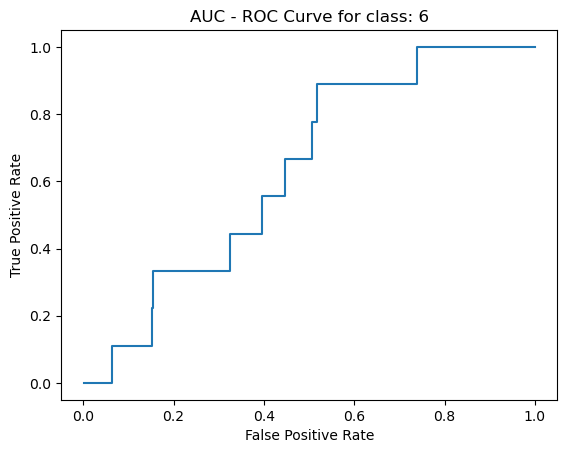

7


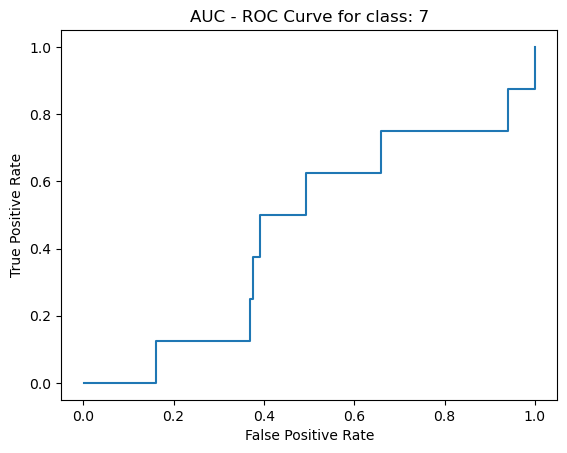

8


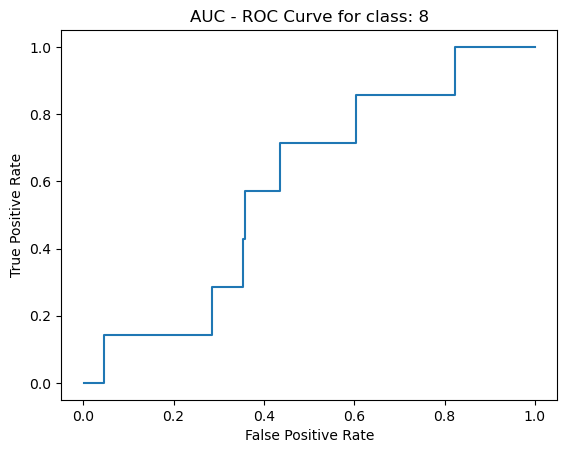

9


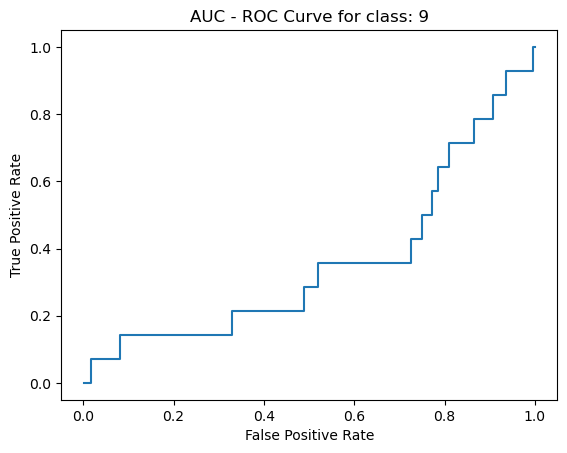

10


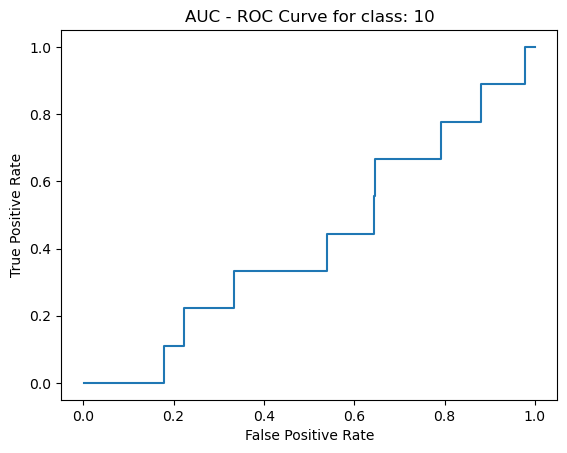

11


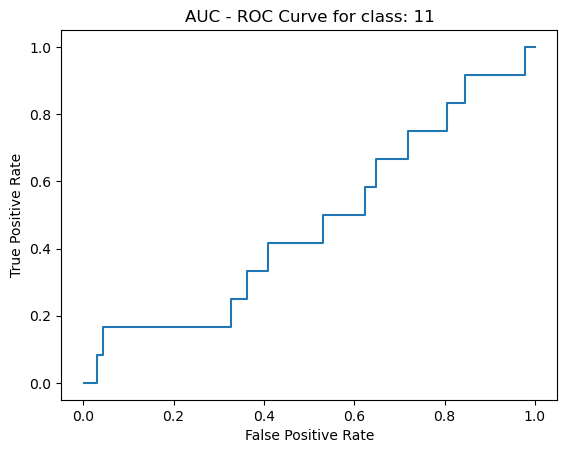

12


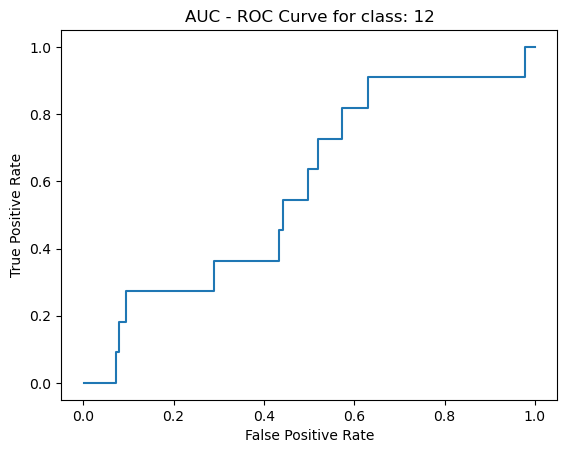

13


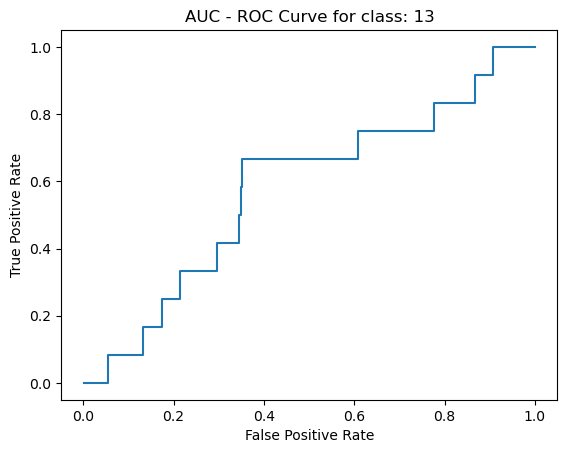

14


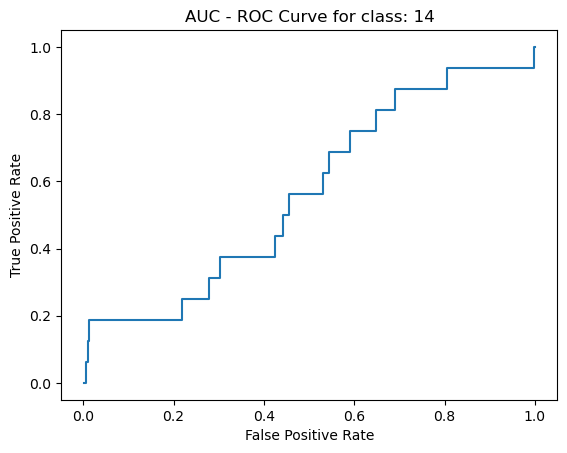

15


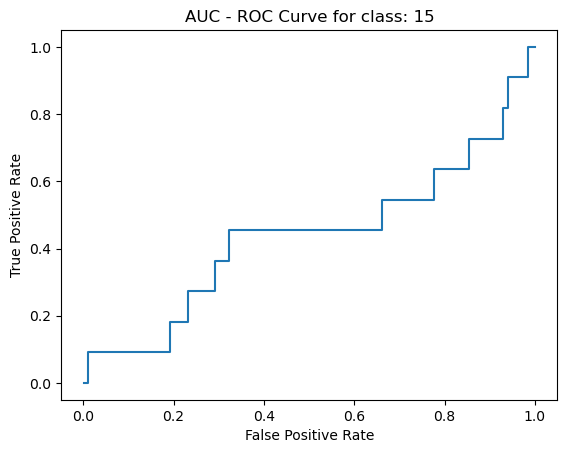

16


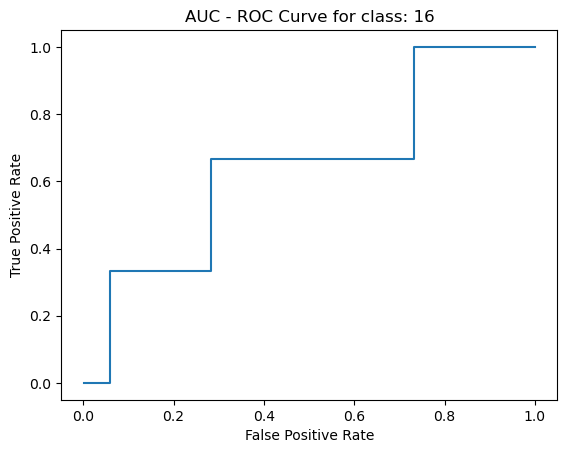

17


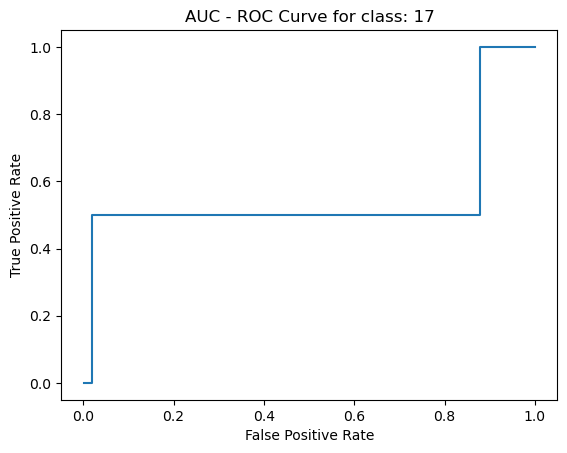

18


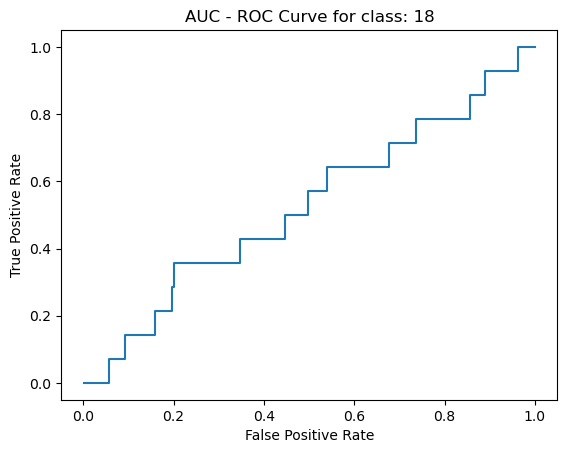

19


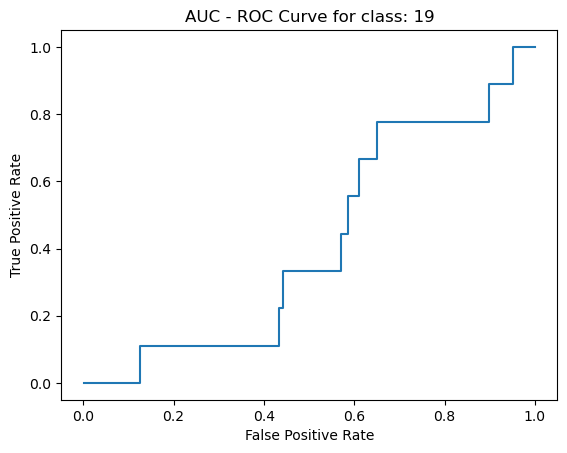

20


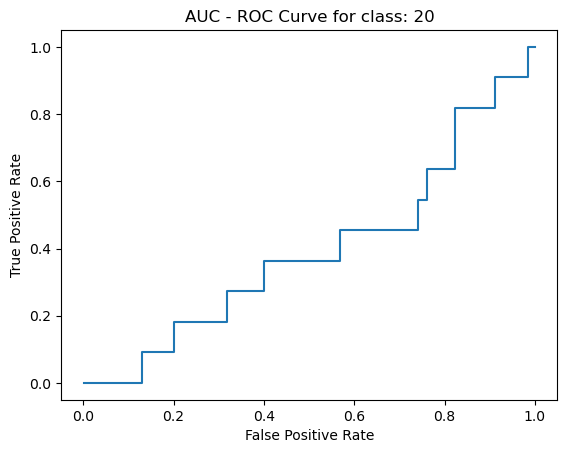

21


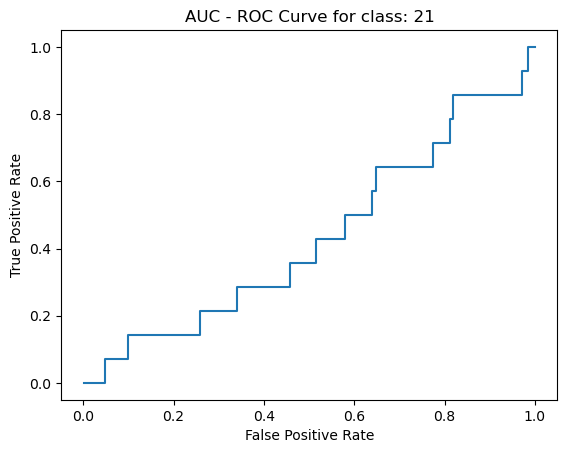

22


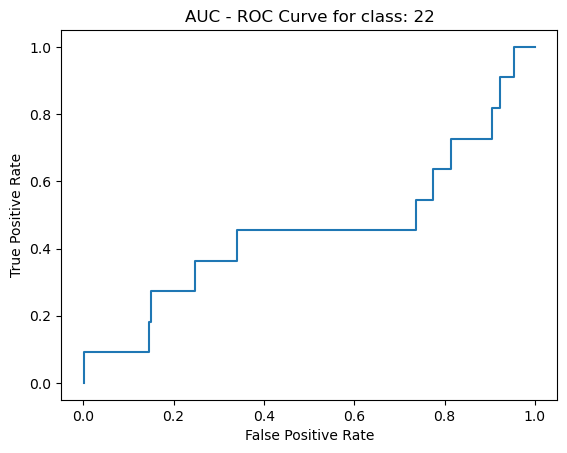

23


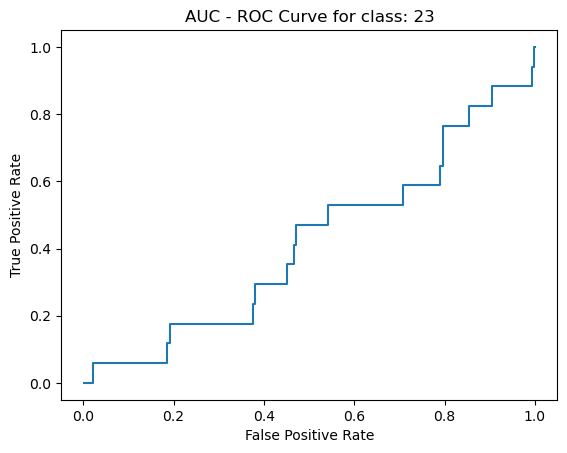

25


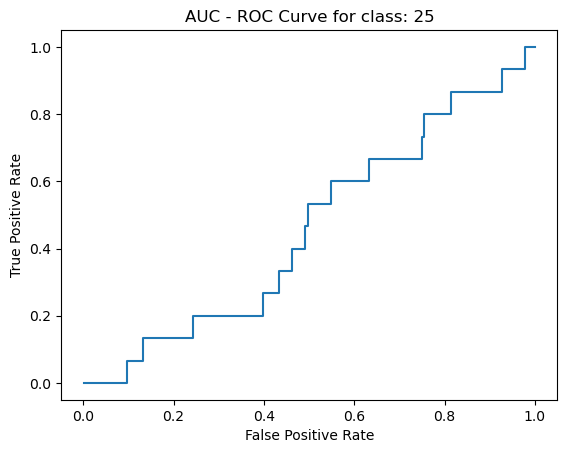

26


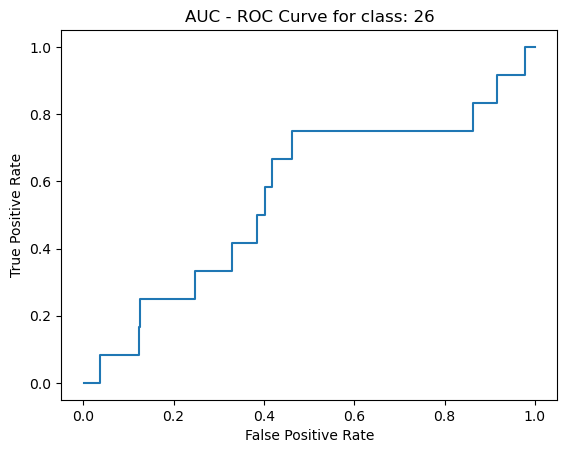

27


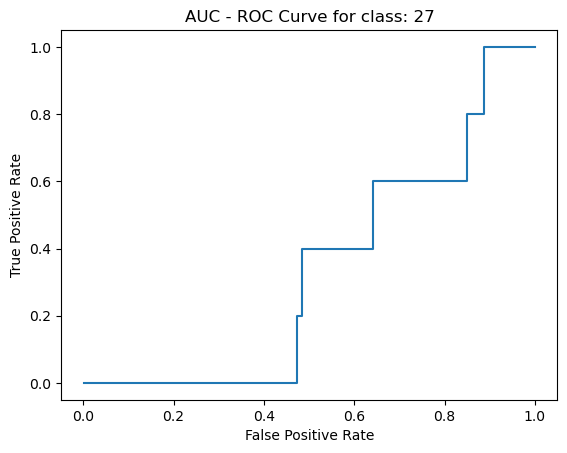

28


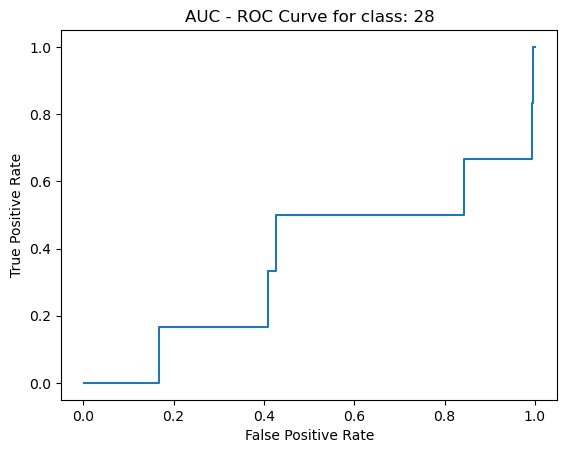

29


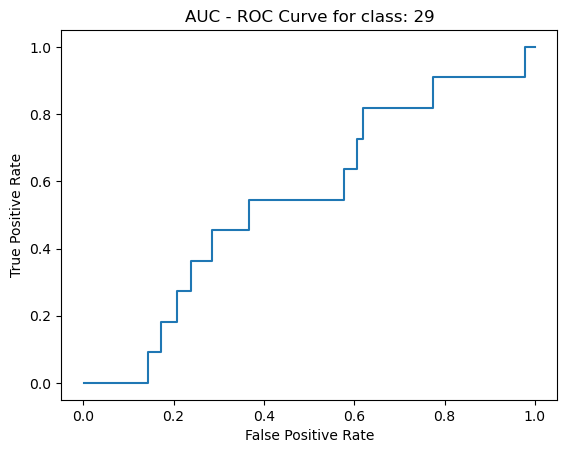

30


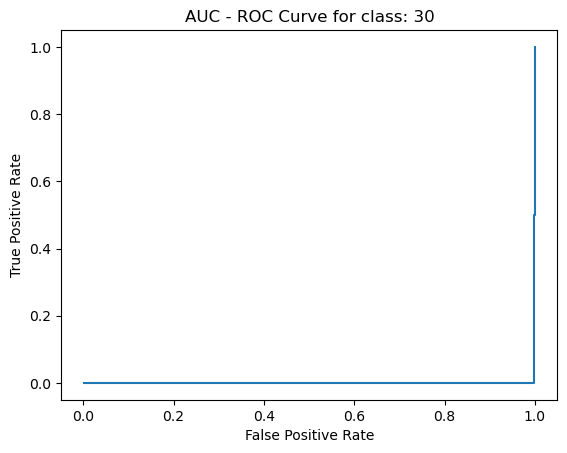

31


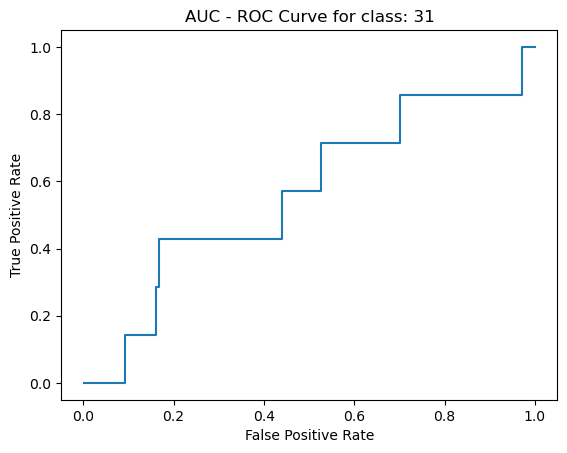

32


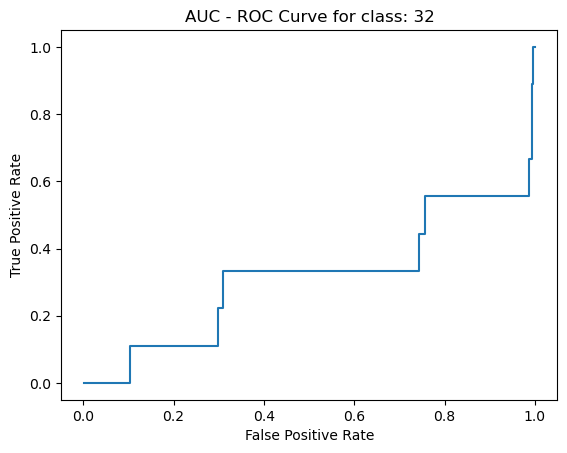

33


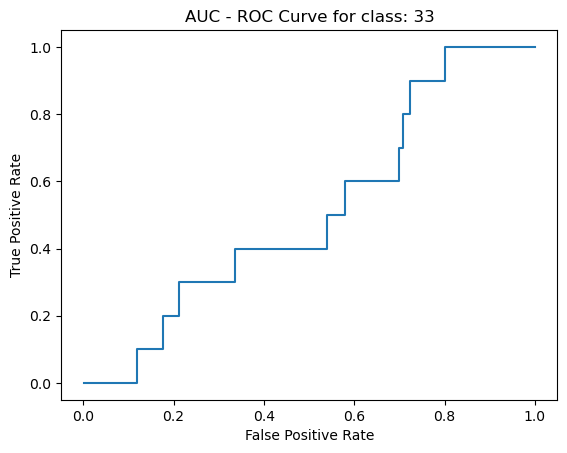

34


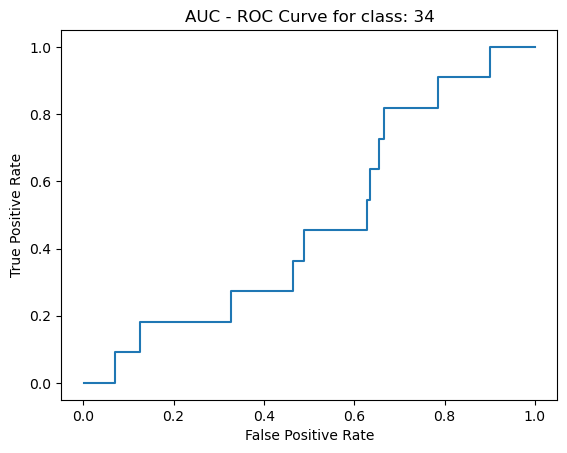

35


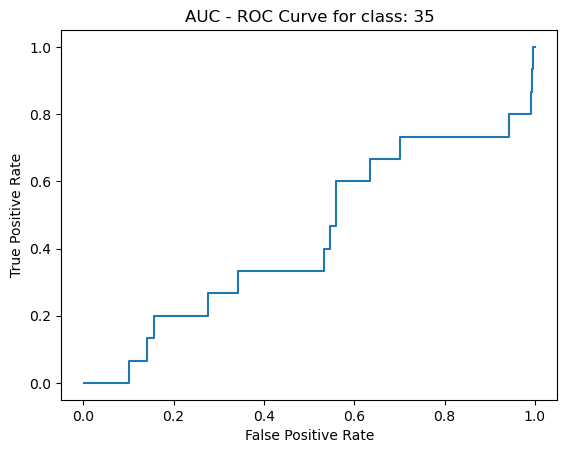

36


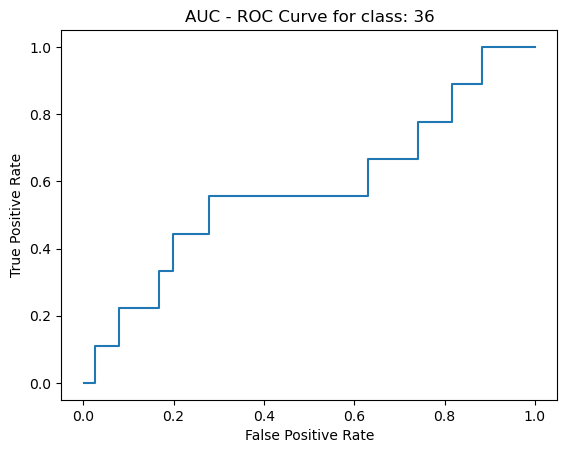

37


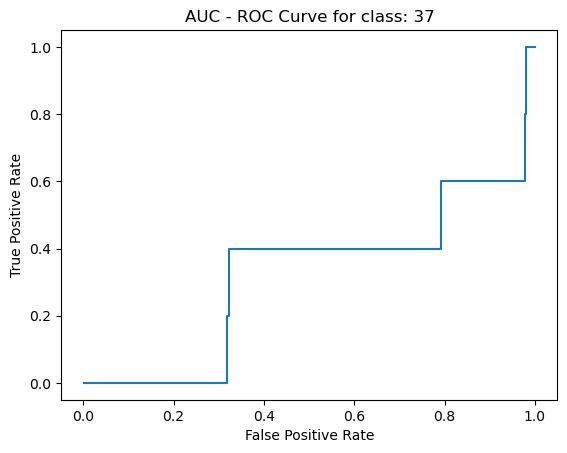

38


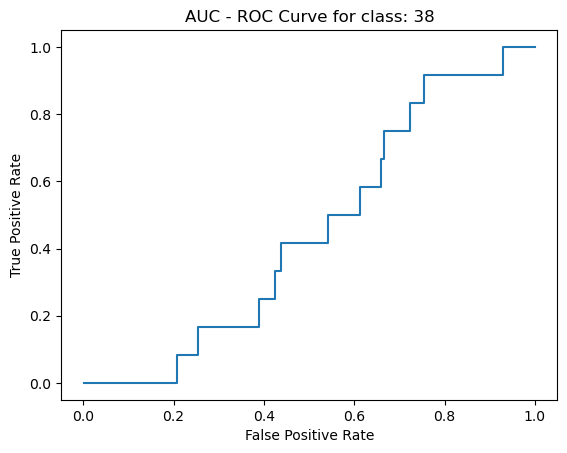

39


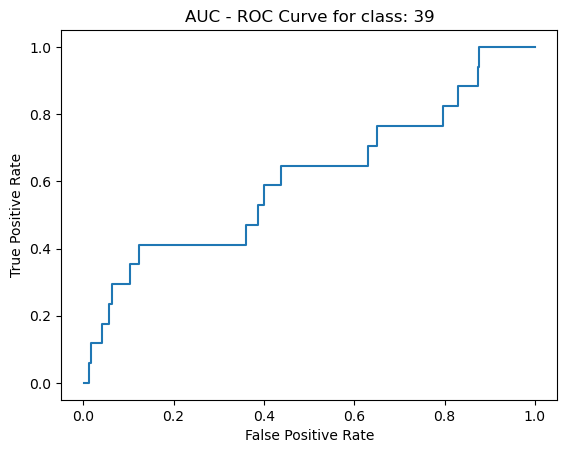

40


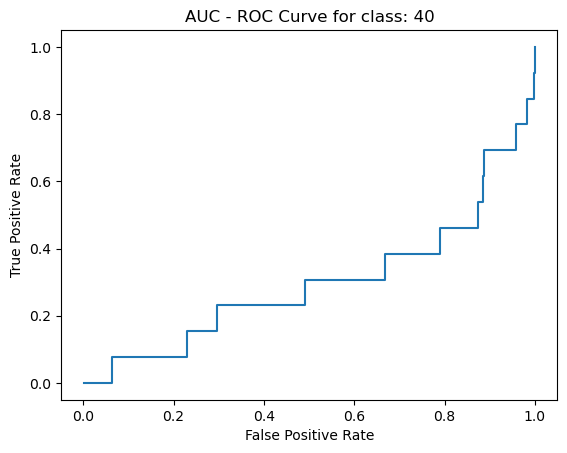

41


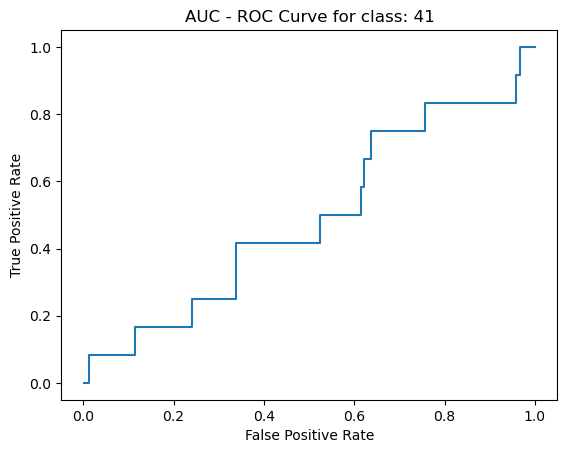

42


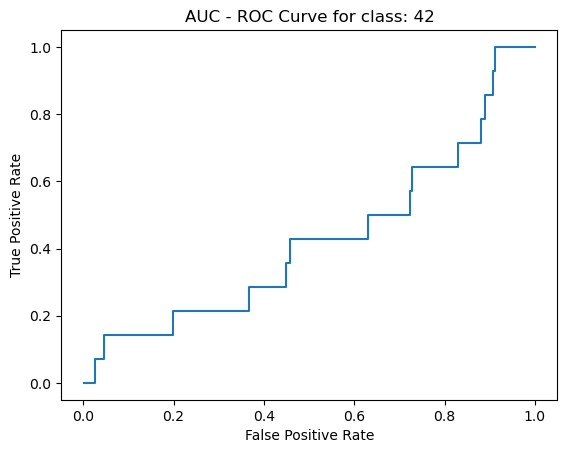

43


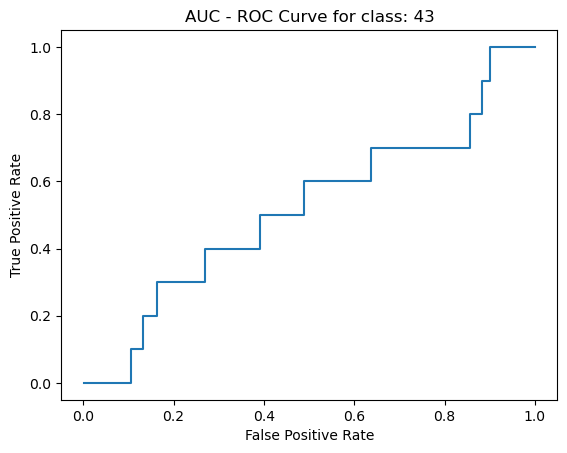

44


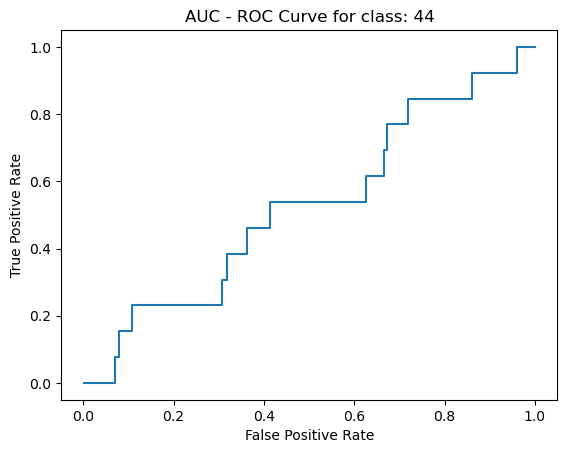

45


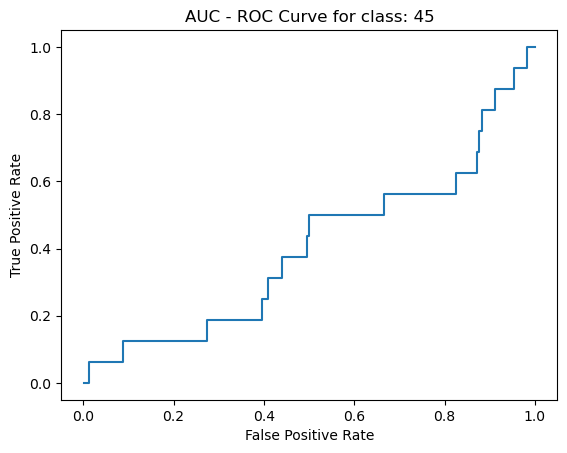

46


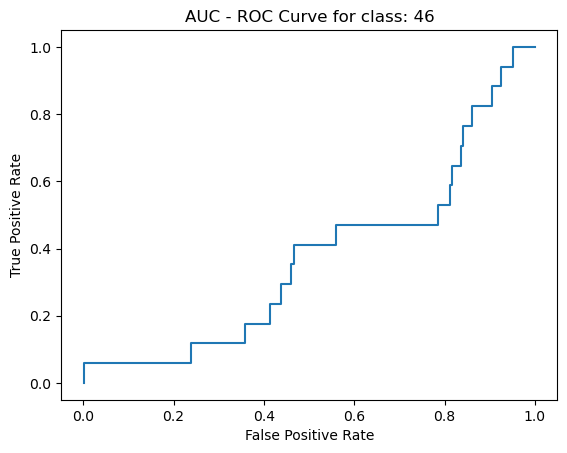

47


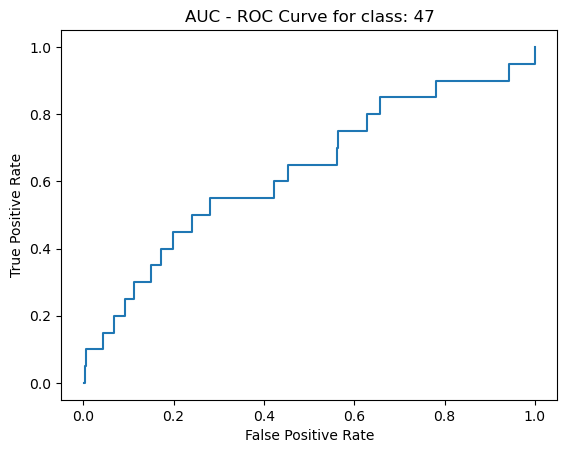

48


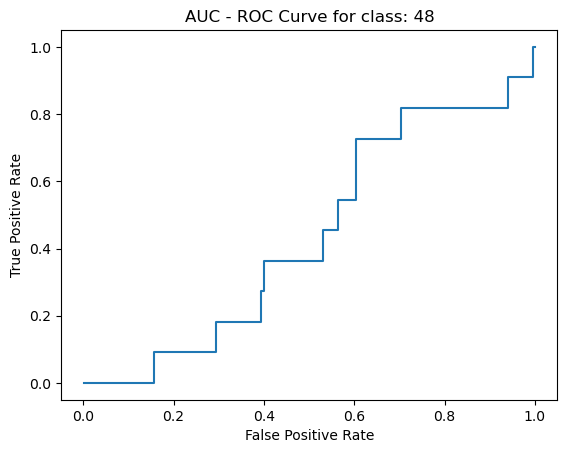

49


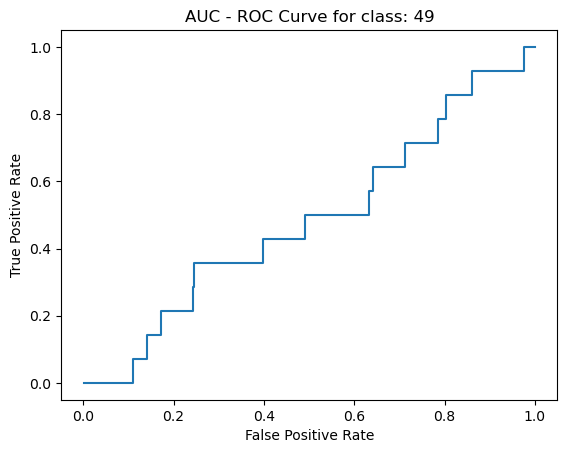

50


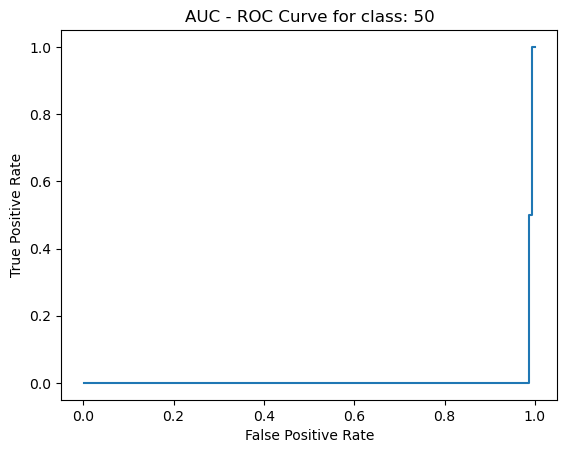

51


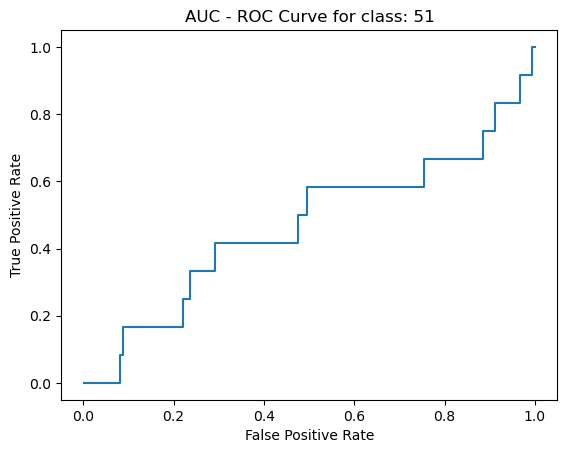

52


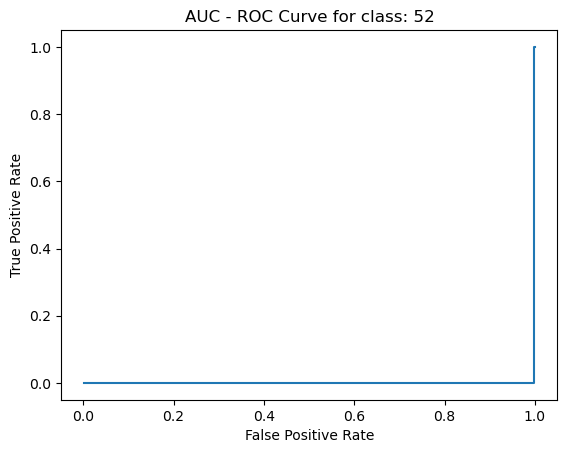

53


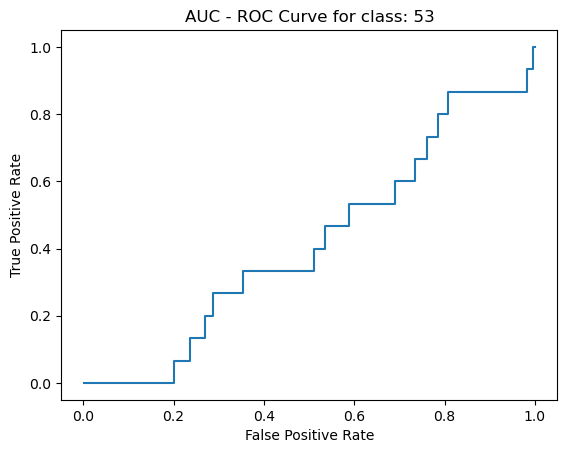

54


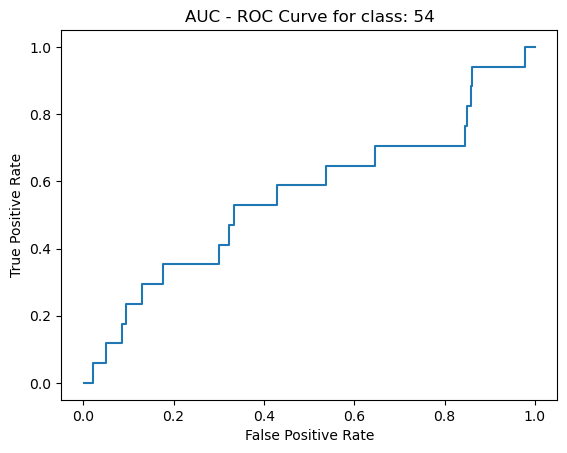

55


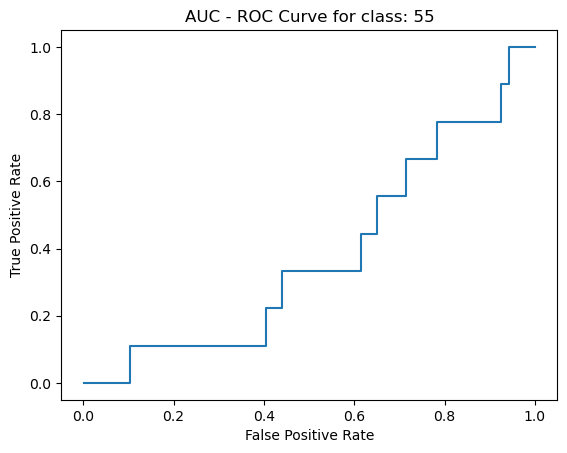

56


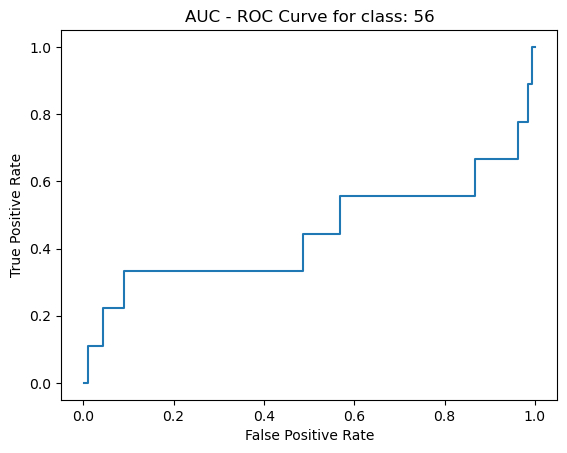

57


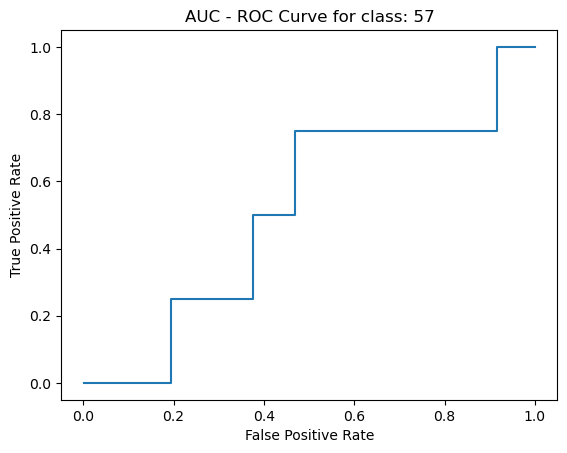

58


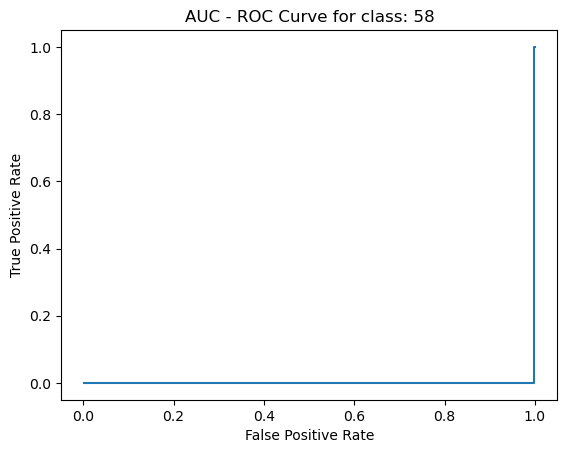

59


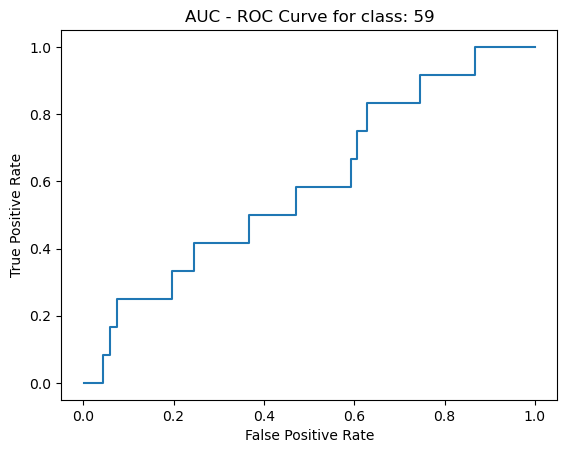

60


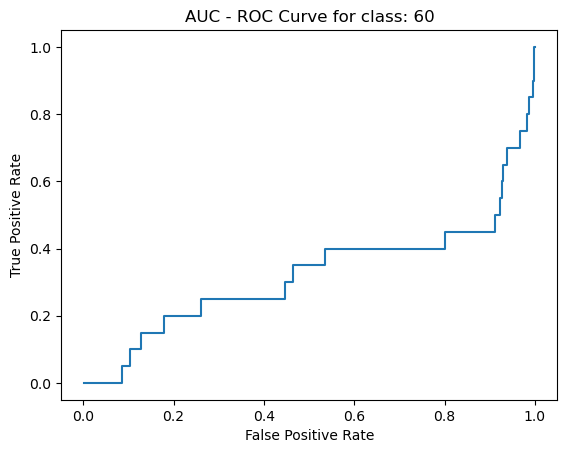

61


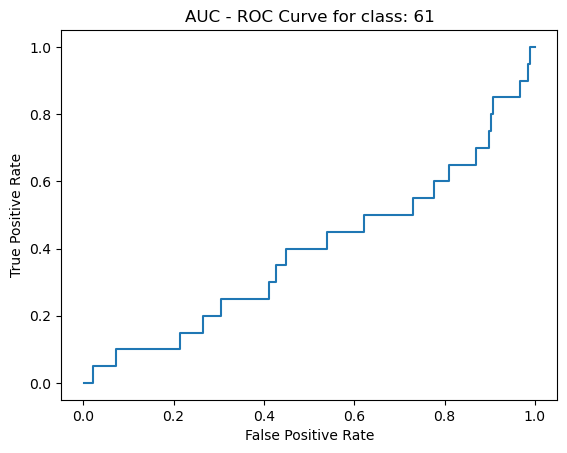

62


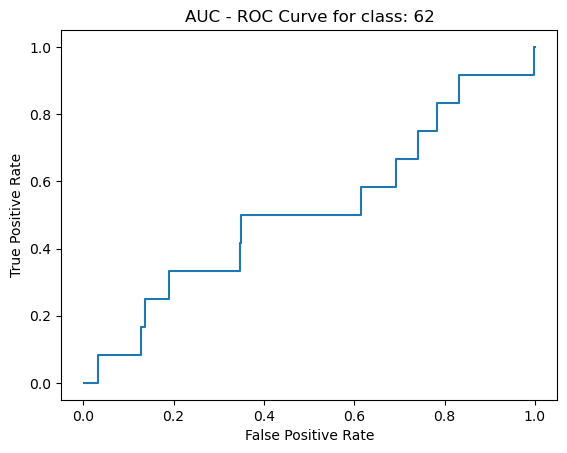

63


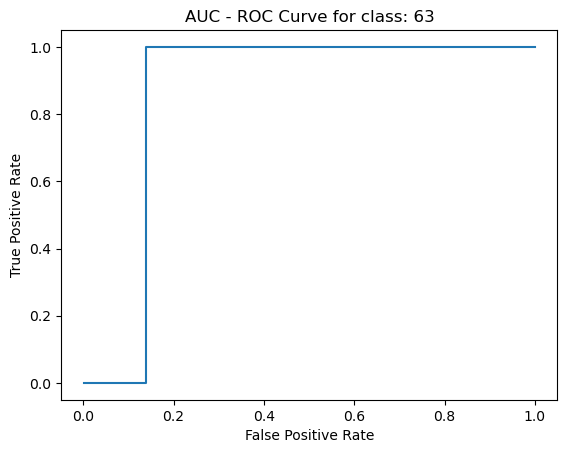

64


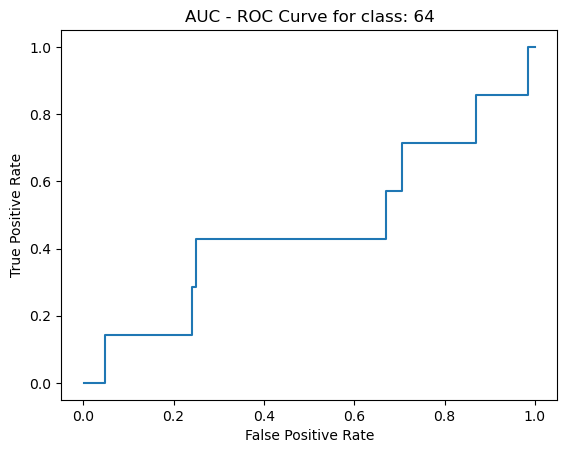

65


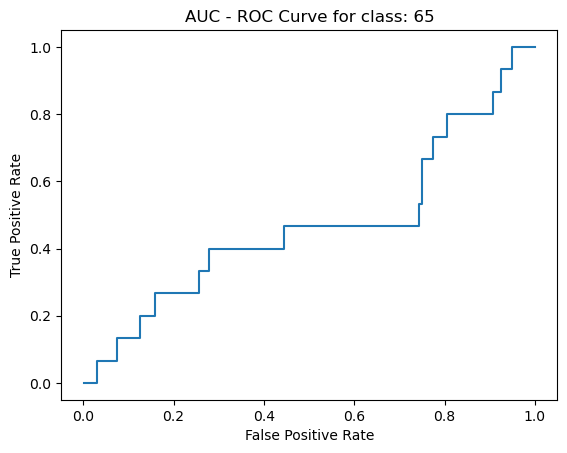

66


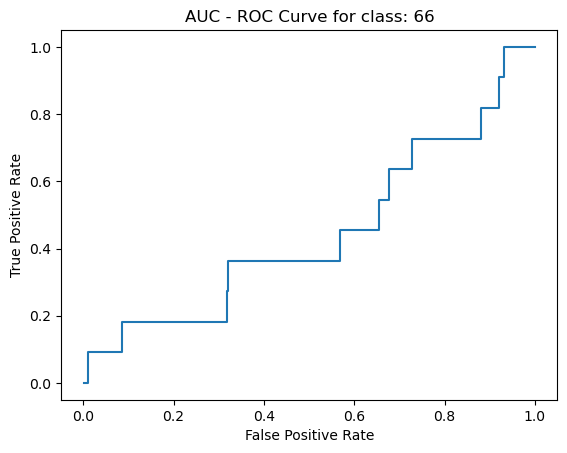

68


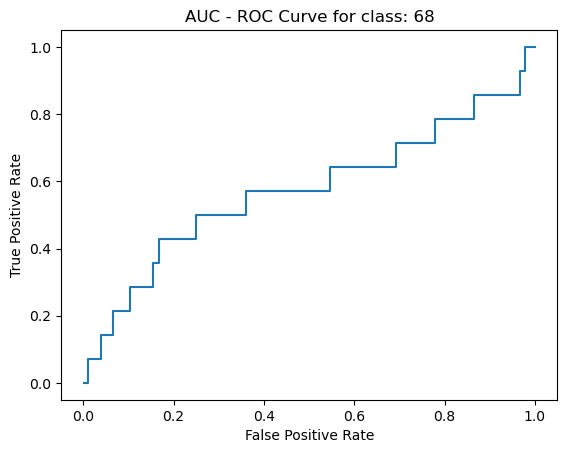

69


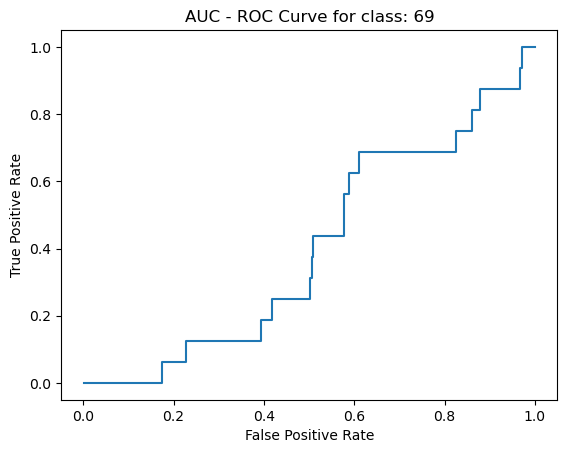

70


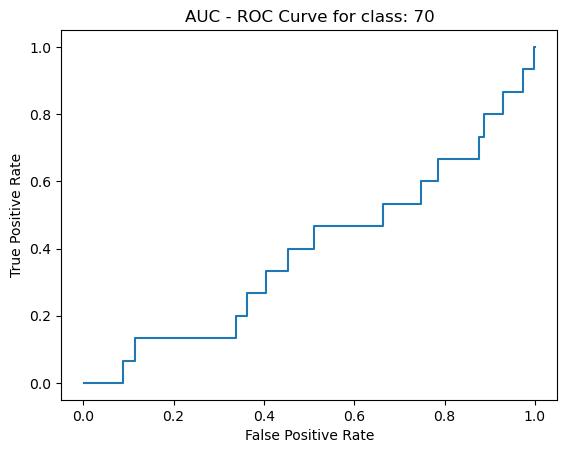

71


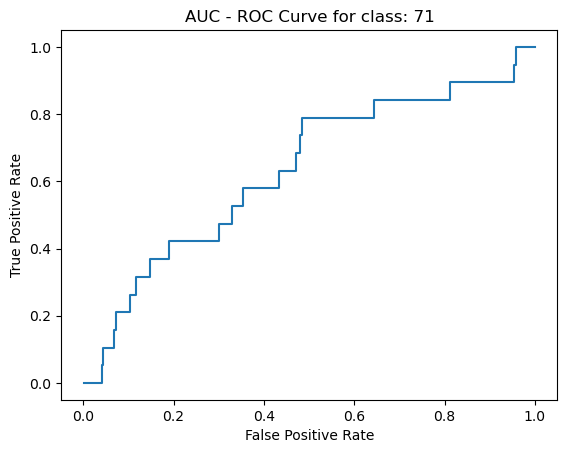

72


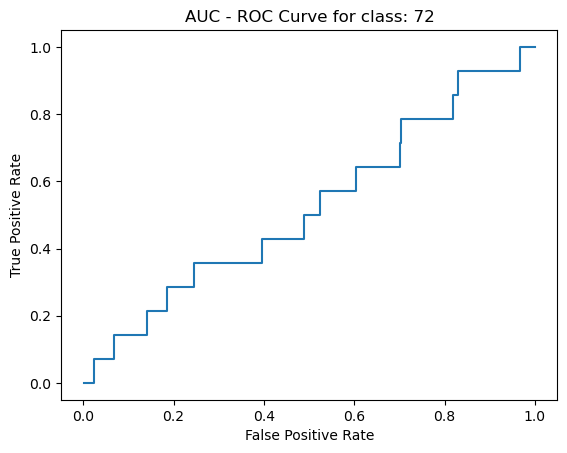

In [56]:
AUC_ROC_one_vs_all(y_test.flatten())

# Вывод - всё отвратительно